# Method 9 - Best Ideas High Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
best_ideas = best_ideas[best_ideas['focus_pct'] > (2 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

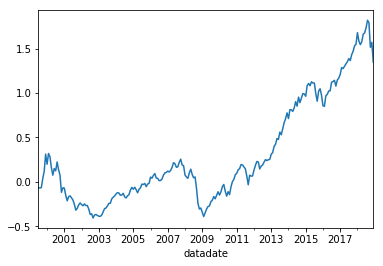

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.312460
2000-12-31   -0.288834
2001-12-31   -0.183273
2002-12-31   -0.183786
2003-12-31    0.350747
2004-12-31    0.116268
2005-12-31    0.049465
2006-12-31    0.124361
2007-12-31    0.068368
2008-12-31   -0.403429
2009-12-31    0.259148
2010-12-31    0.217152
2011-12-31   -0.013493
2012-12-31    0.175196
2013-12-31    0.417646
2014-12-31    0.119645
2015-12-31   -0.006804
2016-12-31    0.097314
2017-12-31    0.175673
2018-12-31   -0.079452
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     561.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.91e-117
Time:                        20:16:56   Log-Likelihood:                 659.18
No. Observations:                 234   AIC:                            -1308.
Df Residuals:                     229   BIC:                            -1291.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.257      0.797      -0.002       0.002
mktrf          0.9958      0.027     36.510      0.000       0.942       1.050
me             0.2634      0.032      8.303      0.000       0.201       0.326
ia            -0.3056      0.048     -6.337      0.000      -0.401      -0.211
roe            0.1828      0.041      4.429      0.000       0.101       0.264
==============================================================================
Omnibus:                       45.360   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              572.207
Skew:                          -0.000   Prob(JB):                    5.58e-125
Kurtosis:                      10.661   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     230.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.02e-79
Time:                        20:16:56   Log-Likelihood:                 659.18
No. Observations:                 234   AIC:                            -1308.
Df Residuals:                     229   BIC:                            -1291.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.257      0.797      -0.002       0.002
mktrf          0.9958      0.034     29.464      0.000       0.930       1.062
me             0.2634      0.035      7.604      0.000       0.196       0.331
ia            -0.3056      0.102     -3.005      0.003      -0.505      -0.106
roe            0.1828      0.055      3.322      0.001       0.075       0.291
==============================================================================
Omnibus:                       45.360   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              572.207
Skew:                          -0.000   Prob(JB):                    5.58e-125
Kurtosis:                      10.661   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     252.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.12e-82
Time:                        20:16:56   Log-Likelihood:                 659.18
No. Observations:                 234   AIC:                            -1308.
Df Residuals:                     229   BIC:                            -1291.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.252      0.801      -0.002       0.002
mktrf          0.9958      0.032     30.779      0.000       0.932       1.059
me             0.2634      0.031      8.601      0.000       0.203       0.323
ia            -0.3056      0.100     -3.068      0.002      -0.501      -0.110
roe            0.1828      0.052      3.538      0.000       0.082       0.284
==============================================================================
Omnibus:                       45.360   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              572.207
Skew:                          -0.000   Prob(JB):                    5.58e-125
Kurtosis:                      10.661   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     413.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.38e-112
Time:                        20:16:56   Log-Likelihood:                 651.05
No. Observations:                 234   AIC:                            -1290.
Df Residuals:                     228   BIC:                            -1269.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.462      0.645      -0.002       0.003
mktrf          0.9552      0.028     33.687      0.000       0.899       1.011
smb            0.2510      0.037      6.708      0.000       0.177       0.325
hml           -0.1581      0.044     -3.583      0.000      -0.245      -0.071
rmw            0.0306      0.050      0.613      0.541      -0.068       0.129
cma           -0.0989      0.063     -1.560      0.120      -0.224       0.026
==============================================================================
Omnibus:                       37.186   Durbin-Watson:                   2.263
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              303.055
Skew:                           0.140   Prob(JB):                     1.56e-66
Kurtosis:                       8.568   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     270.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.08e-93
Time:                        20:16:56   Log-Likelihood:                 651.05
No. Observations:                 234   AIC:                            -1290.
Df Residuals:                     228   BIC:                            -1269.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.520      0.603      -0.001       0.002
mktrf          0.9552      0.033     28.799      0.000       0.890       1.020
smb            0.2510      0.055      4.592      0.000       0.144       0.358
hml           -0.1581      0.053     -2.964      0.003      -0.263      -0.054
rmw            0.0306      0.083      0.370      0.712      -0.131       0.193
cma           -0.0989      0.136     -0.729      0.466      -0.365       0.167
==============================================================================
Omnibus:                       37.186   Durbin-Watson:                   2.263
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              303.055
Skew:                           0.140   Prob(JB):                     1.56e-66
Kurtosis:                       8.568   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     383.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.36e-109
Time:                        20:16:56   Log-Likelihood:                 651.05
No. Observations:                 234   AIC:                            -1290.
Df Residuals:                     228   BIC:                            -1269.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.511      0.609      -0.001       0.002
mktrf          0.9552      0.033     29.134      0.000       0.891       1.019
smb            0.2510      0.052      4.870      0.000       0.150       0.352
hml           -0.1581      0.053     -2.987      0.003      -0.262      -0.054
rmw            0.0306      0.089      0.345      0.730      -0.143       0.204
cma           -0.0989      0.135     -0.732      0.464      -0.364       0.166
==============================================================================
Omnibus:                       37.186   Durbin-Watson:                   2.263
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              303.055
Skew:                           0.140   Prob(JB):                     1.56e-66
Kurtosis:                       8.568   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     799.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.14e-133
Time:                        20:16:56   Log-Likelihood:                 697.31
No. Observations:                 234   AIC:                            -1385.
Df Residuals:                     229   BIC:                            -1367.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.881      0.379      -0.002       0.001
mktrf          1.0565      0.021     49.518      0.000       1.014       1.098
smb            0.1549      0.027      5.816      0.000       0.102       0.207
hml           -0.0993      0.026     -3.755      0.000      -0.151      -0.047
umd            0.1885      0.017     10.859      0.000       0.154       0.223
==============================================================================
Omnibus:                       32.744   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.505
Skew:                          -0.330   Prob(JB):                     6.98e-37
Kurtosis:                       7.080   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     672.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.69e-125
Time:                        20:16:56   Log-Likelihood:                 697.31
No. Observations:                 234   AIC:                            -1385.
Df Residuals:                     229   BIC:                            -1367.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -1.031      0.302      -0.002       0.001
mktrf          1.0565      0.040     26.415      0.000       0.978       1.135
smb            0.1549      0.036      4.307      0.000       0.084       0.225
hml           -0.0993      0.031     -3.221      0.001      -0.160      -0.039
umd            0.1885      0.033      5.687      0.000       0.124       0.253
==============================================================================
Omnibus:                       32.744   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.505
Skew:                          -0.330   Prob(JB):                     6.98e-37
Kurtosis:                       7.080   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     776.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.93e-132
Time:                        20:16:56   Log-Likelihood:                 697.31
No. Observations:                 234   AIC:                            -1385.
Df Residuals:                     229   BIC:                            -1367.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.963      0.335      -0.002       0.001
mktrf          1.0565      0.045     23.657      0.000       0.969       1.144
smb            0.1549      0.040      3.874      0.000       0.077       0.233
hml           -0.0993      0.031     -3.240      0.001      -0.159      -0.039
umd            0.1885      0.034      5.512      0.000       0.121       0.256
==============================================================================
Omnibus:                       32.744   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.505
Skew:                          -0.330   Prob(JB):                     6.98e-37
Kurtosis:                       7.080   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     221.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.79e-53
Time:                        20:16:56   Log-Likelihood:                 309.84
No. Observations:                 120   AIC:                            -609.7
Df Residuals:                     115   BIC:                            -595.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.002     -0.752      0.454      -0.005       0.002
mktrf          1.0200      0.048     21.172      0.000       0.925       1.115
me             0.2882      0.048      6.057      0.000       0.194       0.382
ia            -0.3807      0.075     -5.109      0.000      -0.528      -0.233
roe            0.2593      0.066      3.931      0.000       0.129       0.390
==============================================================================
Omnibus:                       19.863   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.254
Skew:                           0.072   Prob(JB):                     5.13e-24
Kurtosis:                       7.629   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     85.26
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.74e-33
Time:                        20:16:56   Log-Likelihood:                 309.84
No. Observations:                 120   AIC:                            -609.7
Df Residuals:                     115   BIC:                            -595.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.002     -0.740      0.459      -0.005       0.002
mktrf          1.0200      0.059     17.410      0.000       0.905       1.135
me             0.2882      0.043      6.703      0.000       0.204       0.372
ia            -0.3807      0.138     -2.768      0.006      -0.650      -0.111
roe            0.2593      0.063      4.103      0.000       0.135       0.383
==============================================================================
Omnibus:                       19.863   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.254
Skew:                           0.072   Prob(JB):                     5.13e-24
Kurtosis:                       7.629   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     89.13
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.58e-34
Time:                        20:16:56   Log-Likelihood:                 309.84
No. Observations:                 120   AIC:                            -609.7
Df Residuals:                     115   BIC:                            -595.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.002     -0.773      0.439      -0.005       0.002
mktrf          1.0200      0.054     18.743      0.000       0.913       1.127
me             0.2882      0.040      7.216      0.000       0.210       0.366
ia            -0.3807      0.135     -2.829      0.005      -0.644      -0.117
roe            0.2593      0.046      5.601      0.000       0.169       0.350
==============================================================================
Omnibus:                       19.863   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.254
Skew:                           0.072   Prob(JB):                     5.13e-24
Kurtosis:                       7.629   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     150.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.46e-48
Time:                        20:16:56   Log-Likelihood:                 301.86
No. Observations:                 120   AIC:                            -591.7
Df Residuals:                     114   BIC:                            -575.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.294      0.769      -0.003       0.004
mktrf          0.9480      0.055     17.383      0.000       0.840       1.056
smb            0.2596      0.062      4.203      0.000       0.137       0.382
hml           -0.1877      0.076     -2.480      0.015      -0.338      -0.038
rmw            0.0532      0.089      0.596      0.553      -0.124       0.230
cma           -0.1122      0.098     -1.147      0.254      -0.306       0.082
==============================================================================
Omnibus:                       12.470   Durbin-Watson:                   2.339
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               36.326
Skew:                           0.116   Prob(JB):                     1.29e-08
Kurtosis:                       5.685   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     89.86
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.79e-38
Time:                        20:16:56   Log-Likelihood:                 301.86
No. Observations:                 120   AIC:                            -591.7
Df Residuals:                     114   BIC:                            -575.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.337      0.736      -0.003       0.004
mktrf          0.9480      0.062     15.334      0.000       0.827       1.069
smb            0.2596      0.078      3.346      0.001       0.108       0.412
hml           -0.1877      0.080     -2.357      0.018      -0.344      -0.032
rmw            0.0532      0.120      0.443      0.658      -0.182       0.289
cma           -0.1122      0.174     -0.643      0.520      -0.454       0.230
==============================================================================
Omnibus:                       12.470   Durbin-Watson:                   2.339
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               36.326
Skew:                           0.116   Prob(JB):                     1.29e-08
Kurtosis:                       5.685   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     99.27
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.22e-40
Time:                        20:16:56   Log-Likelihood:                 301.86
No. Observations:                 120   AIC:                            -591.7
Df Residuals:                     114   BIC:                            -575.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.330      0.741      -0.003       0.004
mktrf          0.9480      0.059     15.969      0.000       0.832       1.064
smb            0.2596      0.073      3.569      0.000       0.117       0.402
hml           -0.1877      0.076     -2.457      0.014      -0.338      -0.038
rmw            0.0532      0.121      0.438      0.661      -0.185       0.291
cma           -0.1122      0.173     -0.649      0.517      -0.451       0.227
==============================================================================
Omnibus:                       12.470   Durbin-Watson:                   2.339
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               36.326
Skew:                           0.116   Prob(JB):                     1.29e-08
Kurtosis:                       5.685   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     374.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.52e-65
Time:                        20:16:56   Log-Likelihood:                 338.40
No. Observations:                 120   AIC:                            -666.8
Df Residuals:                     115   BIC:                            -652.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.548e-05      0.001     -0.011      0.991      -0.003       0.003
mktrf          1.1159      0.033     33.355      0.000       1.050       1.182
smb            0.1037      0.038      2.721      0.008       0.028       0.179
hml           -0.1232      0.038     -3.229      0.002      -0.199      -0.048
umd            0.2379      0.024     10.115      0.000       0.191       0.285
==============================================================================
Omnibus:                       17.292   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.695
Skew:                          -0.616   Prob(JB):                     1.31e-07
Kurtosis:                       5.196   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     379.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.98e-65
Time:                        20:16:56   Log-Likelihood:                 338.40
No. Observations:                 120   AIC:                            -666.8
Df Residuals:                     115   BIC:                            -652.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.548e-05      0.001     -0.015      0.988      -0.002       0.002
mktrf          1.1159      0.050     22.492      0.000       1.019       1.213
smb            0.1037      0.039      2.625      0.009       0.026       0.181
hml           -0.1232      0.033     -3.729      0.000      -0.188      -0.058
umd            0.2379      0.037      6.353      0.000       0.165       0.311
==============================================================================
Omnibus:                       17.292   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.695
Skew:                          -0.616   Prob(JB):                     1.31e-07
Kurtosis:                       5.196   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     516.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.87e-72
Time:                        20:16:56   Log-Likelihood:                 338.40
No. Observations:                 120   AIC:                            -666.8
Df Residuals:                     115   BIC:                            -652.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.548e-05      0.001     -0.016      0.988      -0.002       0.002
mktrf          1.1159      0.050     22.385      0.000       1.018       1.214
smb            0.1037      0.043      2.405      0.016       0.019       0.188
hml           -0.1232      0.030     -4.131      0.000      -0.182      -0.065
umd            0.2379      0.034      7.029      0.000       0.172       0.304
==============================================================================
Omnibus:                       17.292   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.695
Skew:                          -0.616   Prob(JB):                     1.31e-07
Kurtosis:                       5.196   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     672.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.79e-76
Time:                        20:16:56   Log-Likelihood:                 394.09
No. Observations:                 114   AIC:                            -778.2
Df Residuals:                     109   BIC:                            -764.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.396      0.165      -0.000       0.003
mktrf          0.9697      0.023     42.278      0.000       0.924       1.015
me             0.2198      0.035      6.208      0.000       0.150       0.290
ia            -0.1497      0.049     -3.048      0.003      -0.247      -0.052
roe            0.0491      0.043      1.137      0.258      -0.036       0.135
==============================================================================
Omnibus:                        0.913   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.634   Jarque-Bera (JB):                0.875
Skew:                           0.209   Prob(JB):                        0.646
Kurtosis:                       2.900   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1039.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.54e-86
Time:                        20:16:56   Log-Likelihood:                 394.09
No. Observations:                 114   AIC:                            -778.2
Df Residuals:                     109   BIC:                            -764.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.427      0.154      -0.000       0.003
mktrf          0.9697      0.020     48.461      0.000       0.930       1.009
me             0.2198      0.046      4.829      0.000       0.131       0.309
ia            -0.1497      0.044     -3.425      0.001      -0.235      -0.064
roe            0.0491      0.040      1.235      0.217      -0.029       0.127
==============================================================================
Omnibus:                        0.913   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.634   Jarque-Bera (JB):                0.875
Skew:                           0.209   Prob(JB):                        0.646
Kurtosis:                       2.900   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1276.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.56e-90
Time:                        20:16:56   Log-Likelihood:                 394.09
No. Observations:                 114   AIC:                            -778.2
Df Residuals:                     109   BIC:                            -764.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.282      0.200      -0.001       0.003
mktrf          0.9697      0.020     49.506      0.000       0.931       1.008
me             0.2198      0.045      4.853      0.000       0.131       0.309
ia            -0.1497      0.037     -4.056      0.000      -0.222      -0.077
roe            0.0491      0.037      1.340      0.180      -0.023       0.121
==============================================================================
Omnibus:                        0.913   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.634   Jarque-Bera (JB):                0.875
Skew:                           0.209   Prob(JB):                        0.646
Kurtosis:                       2.900   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     580.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.78e-76
Time:                        20:16:56   Log-Likelihood:                 398.69
No. Observations:                 114   AIC:                            -785.4
Df Residuals:                     108   BIC:                            -769.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.260      0.795      -0.001       0.002
mktrf          0.9723      0.021     46.066      0.000       0.930       1.014
smb            0.2258      0.034      6.589      0.000       0.158       0.294
hml           -0.0983      0.044     -2.250      0.026      -0.185      -0.012
rmw            0.0328      0.054      0.614      0.541      -0.073       0.139
cma           -0.0862      0.068     -1.269      0.207      -0.221       0.048
==============================================================================
Omnibus:                        2.218   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.330   Jarque-Bera (JB):                2.248
Skew:                           0.303   Prob(JB):                        0.325
Kurtosis:                       2.673   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     963.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.92e-88
Time:                        20:16:56   Log-Likelihood:                 398.69
No. Observations:                 114   AIC:                            -785.4
Df Residuals:                     108   BIC:                            -769.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.275      0.783      -0.001       0.002
mktrf          0.9723      0.023     41.406      0.000       0.926       1.018
smb            0.2258      0.046      4.922      0.000       0.136       0.316
hml           -0.0983      0.042     -2.364      0.018      -0.180      -0.017
rmw            0.0328      0.052      0.629      0.529      -0.070       0.135
cma           -0.0862      0.052     -1.644      0.100      -0.189       0.017
==============================================================================
Omnibus:                        2.218   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.330   Jarque-Bera (JB):                2.248
Skew:                           0.303   Prob(JB):                        0.325
Kurtosis:                       2.673   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     1561.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.05e-99
Time:                        20:16:57   Log-Likelihood:                 398.69
No. Observations:                 114   AIC:                            -785.4
Df Residuals:                     108   BIC:                            -769.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.250      0.802      -0.001       0.002
mktrf          0.9723      0.024     41.001      0.000       0.926       1.019
smb            0.2258      0.046      4.960      0.000       0.137       0.315
hml           -0.0983      0.037     -2.654      0.008      -0.171      -0.026
rmw            0.0328      0.060      0.547      0.584      -0.085       0.150
cma           -0.0862      0.055     -1.567      0.117      -0.194       0.022
==============================================================================
Omnibus:                        2.218   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.330   Jarque-Bera (JB):                2.248
Skew:                           0.303   Prob(JB):                        0.325
Kurtosis:                       2.673   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     730.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.04e-77
Time:                        20:16:57   Log-Likelihood:                 398.61
No. Observations:                 114   AIC:                            -787.2
Df Residuals:                     109   BIC:                            -773.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.031e-05      0.001     -0.014      0.989      -0.001       0.001
mktrf          0.9779      0.021     46.812      0.000       0.937       1.019
smb            0.2181      0.033      6.695      0.000       0.154       0.283
hml           -0.0985      0.034     -2.935      0.004      -0.165      -0.032
umd            0.0330      0.025      1.304      0.195      -0.017       0.083
==============================================================================
Omnibus:                        1.900   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.387   Jarque-Bera (JB):                1.912
Skew:                           0.258   Prob(JB):                        0.384
Kurtosis:                       2.630   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1093.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.97e-87
Time:                        20:16:57   Log-Likelihood:                 398.61
No. Observations:                 114   AIC:                            -787.2
Df Residuals:                     109   BIC:                            -773.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.031e-05      0.001     -0.015      0.988      -0.001       0.001
mktrf          0.9779      0.024     41.211      0.000       0.931       1.024
smb            0.2181      0.041      5.271      0.000       0.137       0.299
hml           -0.0985      0.036     -2.757      0.006      -0.168      -0.028
umd            0.0330      0.022      1.507      0.132      -0.010       0.076
==============================================================================
Omnibus:                        1.900   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.387   Jarque-Bera (JB):                1.912
Skew:                           0.258   Prob(JB):                        0.384
Kurtosis:                       2.630   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1421.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.95e-93
Time:                        20:16:57   Log-Likelihood:                 398.61
No. Observations:                 114   AIC:                            -787.2
Df Residuals:                     109   BIC:                            -773.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.031e-05      0.001     -0.014      0.989      -0.001       0.001
mktrf          0.9779      0.023     43.422      0.000       0.934       1.022
smb            0.2181      0.039      5.636      0.000       0.142       0.294
hml           -0.0985      0.029     -3.341      0.001      -0.156      -0.041
umd            0.0330      0.020      1.620      0.105      -0.007       0.073
==============================================================================
Omnibus:                        1.900   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.387   Jarque-Bera (JB):                1.912
Skew:                           0.258   Prob(JB):                        0.384
Kurtosis:                       2.630   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""